# Homework 5

## Pre Section
In this homework, we will cover:

1. Some basic statistics for relationships describing pairs of random variables
1. Linear regression
1. Assessing the quality of model predictions

In [3]:
##import modules needed for homework
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as lr

## A brief overview of useful statistics

Given $n$, paired, samples $(x_1,y_1),(x_2,y_2),...,(x_n,y_n)$, of the random variables $X,Y$, we may want to deduce from this data whether $X$ and $Y$ seem to be related in some way.  Thankfully, there are certain statistics that can be generated from this data to help answer this question.  

Sample **mean**: 

$$\bar{X} = \frac{\sum_{i=1}^n X_i}{N}$$

Tells us the expected value of a variable

Sample **variance**: 

$$var(X) = \frac{\sum_{i=1}^n (X_i-\bar{X})^2}{N}$$

Tells us the average squared deviation about the variable's mean (spread of variable)

Sample **covariance**: 

$$cov(X, Y) = \frac{\sum_i (X_i-\bar{X}) (Y_i - \bar{Y})}{N}$$

Tells us how the extent to which two variables are related, or the extent to which two variables influence one another.  Large, positive covariance means that if one variable
gets larger or smaller, so does the other.  Large, negative covariance means that one variable being larger or smaller implies the other is smaller or larger.  If random variables are independent, their covariance is zero, but the reverse is not always true.

**Note**:  The covariance of a variable with itself is defined as it's variance, however, due to the precise way these statistics are computed in numpy, these quantities will not be exactly equal.

Sample **correlation**: 

$$corr(X, Y) = \frac{cov(X,Y)}{\sqrt{var(X)}\sqrt{var(Y)}}$$

Though covariance is useful for determining whether or not variables are related, it's hard to interpret, because it lacks a sense of scale.  Correlation is a normalized version of covariance, which is constrained to lie between -1 and 1.

**Note**:  When computing variance and covariance, we will sometimes normalize by N-1 instead of N.  Which one is "correct" typically depends on whether the sample mean $\bar{X}$ is known, or if it is also being estimated.  You are free to use whichever you prefer.  Note numpy uses N by default, while pandas uses N-1.  This is the reason behind the previous note.

In [4]:
##Computing statistics in numpy

##Generate some data
##np.random.normal(mu,sigma,n) generates n samples of a normally distributed random variable
##with mean mu and standard deviation sigma

##two seperate arrays of data
X = np.random.normal(0,1,10000)
Y = np.random.normal(0,1,10000)

##mean and var of 1d array
print('mean of X: ', np.mean(X))
print('variance of X: ', np.var(X))

##cov of 2 1d arrays
##this actually returns a matrix, whose i-jth entry is cov(variable i,variable j)
print('cov matrix of X,Y: \n', np.cov(X,Y))
print('covariance of X,Y: ', np.cov(X,Y)[0,1])

##correlation between 2 1d arrays
##note that again, this returns a matrix, whose i-jth entry is corr(var i, var j)
print('correlation matrix of X,Y: \n',np.corrcoef(X,Y))
print('correlation between X,Y: ',np.corrcoef(X,Y)[0,1])
##note the correlation of a variable with itself is 1

mean of X:  0.0034208641945705437
variance of X:  0.9825914135417461
cov matrix of X,Y: 
 [[ 0.98268968 -0.0016514 ]
 [-0.0016514   0.99143065]]
covariance of X,Y:  -0.0016513960105007384
correlation matrix of X,Y: 
 [[ 1.         -0.00167306]
 [-0.00167306  1.        ]]
correlation between X,Y:  -0.0016730613341107998


Note that $cov(X,X)$ does not equal $var(X)$, due to division by $N-1$ in the former, and $N$ in the latter.

In [5]:
##Lets do another example, but with each variable stored as a column in a matrix
##Call X the first colum, Y the second
Z = np.random.normal(0,1,[10000,2]) 
print(Z[:5,:])

[[-1.65847193 -0.54979746]
 [ 1.56511553  1.0127544 ]
 [-0.85496099 -0.18242849]
 [-0.6526211   0.8003411 ]
 [-0.35208134 -0.76577456]]


In [6]:
##get variances, correlations, covariances of columns of Z
print("var of X: ", np.var(Z[:,0]))
print('var of Y: ', np.var(Z[:,1]))
print('var of X and var of Y: ', np.var(Z,axis=0))

##numpy cov function has an annoying construction
##it assumes variables correspond to rows, so we need to flip, or transpose, the matrix
##transpose of a matrix is a new matrix with Z[i,j].T = Z[j,i]


print('cov matrix of X,Y: \n', np.cov(Z.T)) 

##correlation matrix (need to flip again)
print('correlation matrix of X,Y: \n', np.corrcoef(Z.T))

var of X:  0.9661850251899406
var of Y:  0.9920240751781412
var of X and var of Y:  [0.96618503 0.99202408]
cov matrix of X,Y: 
 [[0.96628165 0.00247759]
 [0.00247759 0.99212329]]
correlation matrix of X,Y: 
 [[1.         0.00253044]
 [0.00253044 1.        ]]


## Linear Regression

The goal of most scientific pursuits is the creation of a model which can adequately describe the relationship between one or more dependent (outcome) variables and one or more independent variables (features, or inputs).  While these models are often used to generate predictions of outcomes, given inputs, they can also be used to better understand how quantities are related, i.e., to infer what input variables meaningfully impact a given outcome.


For now, we will only consider a simple case in which we want to predict one output variable $Y$ from a single input variable $X$.  We start by assuming that there is some relationship between these two variables:

$$Y = f(X)$$

and aim to construct some model for, or estimate of, $f(X)$, $\hat{f}(X)$.  


Linear regression starts by assuming what is basically the simplest possible model for $f(X)$, i.e., a linear model:

$$Y = \hat{f}(X) = aX + b$$.

Naturally, such a simple model is unlikely to perfectly describe the relationship between $\textit{any}$ two variables, moreover, it is almost certainly the case that there are other variables that influence $Y$ which are not included in our model.  To account for these shortcomings, linear regression models also include a random component, which is intended to represent the influence of other, external, variables on our outcome, or to account for uncertainty in the specification of our linear model. The full linear regression model is then:

$$Y = \hat{f}(X) + \epsilon = aX + b + \epsilon ,$$

where $\epsilon$ is a random variable, commonly referred to as a noise or error term.  While other choices are possible, for now we assume that $\epsilon$ is a normal (Gaussian) random variable, with mean $0$ and variance $\sigma^2$, $\epsilon \sim \mathcal{N}(0,\sigma^2)$.

A crucial assumption of linear regression is that our noise terms are independent, and identically distributed, across distinct observations of $X$ and $Y$.  More precisely, given $n$ observations of $Y$, $y_1,y_2,...,y_n$, along with $n$ paired inputs $x_1,x_2,...,x_n$, and our model:

$$y_i = ax_i + b + \epsilon_i,$$

we assume $\epsilon_i \sim \mathcal{N}(0,\sigma^2)$ for all $i$, where $\mathcal{N}(0,\sigma^2)$ is shorthand for a normal random variable, with mean 0 and variance $\sigma^2$.

Given data, one "fits" a linear regression model by finding values for the slope $a$ and intercept $b$ that best explains the observed data.  For now, you don't need to understand the mechanics of this estimation procedure, however, if you're interested, you can read more at https://en.wikipedia.org/wiki/Ordinary_least_squares . 


In [67]:
##Fitting a linear regression model in sklearn is as easy as typing .fit

##make data
X = np.random.normal(0,1,100) 
y = 2*X + 1 + np.random.normal(0,.1,100) ##add some noise so its not too easy

##create a linear regression object
my_linear_model = lr() 

##fit it to data (find a and b)
##note, sklearn requires the input X to be n by 1, rather than an array of length n
##numpy arrays can be dynamically reshaped using the .reshape function
##-1 stands for "as long as you can make it"
##so if you have n elements in an array, -1,1 will make it n by 1.
my_linear_model.fit(X.reshape(-1,1),y) 
 
##what are model estimates for a and b?
print('Estimated slope: ', my_linear_model.coef_)
print('Estimated intercept: ',my_linear_model.intercept_) 

Estimated slope:  [1.98698074]
Estimated intercept:  0.986671442938197


array([-3.00071967e+00, -1.72497517e+00,  2.69394160e+00,  2.28070984e+00,
        3.42271030e+00,  8.19585962e-01, -4.67851270e+00,  6.23846007e-01,
        1.09377506e+00, -9.32443226e-01, -9.96752144e-01,  4.58174485e+00,
       -1.43195817e+00,  3.45206226e+00,  2.28031945e+00,  7.38786040e-01,
        1.62410442e+00,  3.23401901e+00, -3.82426399e-01, -3.54254168e+00,
       -1.47827722e+00, -1.05401044e+00, -5.93506860e-01,  2.60673167e+00,
        3.72994905e+00,  2.47852748e+00, -3.72380552e+00, -3.61569779e+00,
       -1.56641058e+00,  9.44354634e-01, -1.96659531e+00,  4.76548408e-01,
        1.56746778e+00,  1.91012165e+00,  2.89765451e+00,  1.52672728e+00,
       -5.22639159e-01,  1.26228142e+00, -3.86738158e-01,  4.05568066e+00,
        2.22297981e+00,  2.00806212e+00,  4.41567763e+00, -1.81014957e+00,
        8.61925970e-01,  6.24989195e+00,  5.03753912e-01,  4.86733092e-01,
        2.52534742e+00,  2.44605880e+00,  3.22429347e+00, -1.39931870e+00,
       -1.16685973e+00, -

In this case, linear regression was a good model because the relationship between $X$
and $Y$ was linear.  The estimated parameters are near their true values.

To assess how well a linear regression fits data without prior knowledge of how $X$ and $Y$ are related, we typically train, or fit, the model, using a subset of our data, then see how accurate its predictions are on a holdout set of testing data.  For now, we'll just see how
accurately it can predict the data on which it was fit.

To do this, we will generate model predictions.  Given a test point $x^*$, predictions under our model will be given: 

$$y^* = \hat{a}x^* + \hat{b},$$

where $\hat{a},\hat{b}$ are our esimated values of $a$ and $b$ generated during our call to .fit().  These predictions can be generated by calling the .predict method of sklearn `LinearRegression` objects.



In [8]:
yhat = my_linear_model.predict(X.reshape(-1,1))
print(yhat)

[ 1.62702727 -0.495831   -1.12073485  3.17099545 -0.8126051  -0.65910152
 -0.81610224  0.78848837 -0.34726483  1.87834353  1.06166277  1.11221548
  2.54040135  2.01357396 -0.56494191  2.93457033  3.11844485  1.58673592
 -0.33992335  1.26814655  0.95527122 -1.22430472  0.257062   -0.9482677
  2.50538821 -0.68533645  0.1245509  -0.31899427  0.66571543  1.91768122
  3.42142847  1.16729859  1.0028017  -0.10391111  0.63157634  2.46647464
  0.36047464 -0.00654492 -0.69998642  0.0808147   2.72437486  2.33137105
  5.0643319  -0.7152455   2.86892965  5.06007077  4.10512244  0.55129999
 -0.57528597  0.11046676  3.27449012  1.19278405  2.86958719  0.34158776
  1.58562861  1.38973903  0.54662168  2.94220558 -1.87358781  0.81101856
  3.88105027 -0.51044914 -0.29478367 -0.49387119  0.40226012  1.42754825
 -0.40095773 -3.20133012 -0.29080235  0.68975596  0.61711122  0.04862763
 -1.06624403  1.45700596  0.18743792  2.16806276  0.72510701 -0.40547598
  6.11370496  1.95672186  2.13177967 -0.20560382 -1.

With predictions in hand, we can then assess the quality of our model by assesing the accuracy of our predictions.  This is typically done via one of two metrics:

Mean squared error: 

$$MSE = \frac{1}{n}\sum_{i=1}^n (y_i-\hat{y}_i)^2$$

Coefficient of determination: 

$$r^2 = 1- \frac{\sum_{i=1}^n (y_i-\hat{y}_i)^2}{\sum_{i=1}^n (y_i-\bar{y})^2}$$

where $\hat{y}_i$ is our prediction for $y_i$ and where $\bar{y}$ is the (sample) mean of $Y$.

While mean squared error is often sufficient for comparing models on a given problem, it lacks a sense of scale.  $r^2$ scores address this shortcoming by scaling mean squared error by the variance of $Y$, and can thus be interpreted as the percent of variability in $Y$ explained by the model and $X$.

## Discussion Question (2 pts)
Personal data is increasingly stored in encrypted formats managed by large tech companies. In cases where a crime has occured, this data may be important to investigations by law enforcement. Apple has famously [refused to crack their encryption or build backdoors](https://www.theverge.com/2020/1/7/21054836/fbi-iphone-unlock-apple-encryption-debate-pensacola-ios-security) into their software to help law enforcement gain access to potential evidence, while [Google has charged law enforcement](https://www.nytimes.com/2020/01/24/technology/google-search-warrants-legal-fees.html) a fee to execute search warrants for user data. **What roles and responsibilities do these private tech companies have to both users and law enforcement when it comes to either sharing or safeguarding user data when a crime has occurred?**  Enter a few sentences addressing this question in the box below.

With the properly document warrants for the government, there shouldn't preventing access to potential evidence linked to a crime, especially when the digitization of information is the new paradigm for how investigations are implemented and how evidence is retrieved. Monetization of user data without the user's consent nor allowing the user to have a stake in the monetization is an issue in itself. Monetization especially shouldn't be prevalent in criminal investigations and large tech companies should be willing to cooperate with law enforcement containing search warrants.

# HW 5

**To make it easier for TAs to grade your work, make sure that all cells are executed so that we can see your results without having to run anything**




In [181]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression as lr

## A: Computing Covariance, Correlation, and $r^2$ in numpy




**Problem 1 (2 points):** Below we have defined an ndarray which records paired observations of two random variables $X$,$Y$.  This ndarray is a $n$ by 2 array, where $n=15$ is the number of paired observations.  Run the code cell below, and generate a scatter plot of your data, with appropriate labels.

In [182]:
q = np.array(
    [
        [ 4.35994902, 10.84003387],
        [ 0.25926232,  6.64625283],
        [ 5.49662478, 12.70709295],
        [ 4.35322393, 10.33309438],
        [ 4.20367802, 10.21407197],
        [ 3.30334821,  8.47051026],
        [ 2.04648634,  7.93047576],
        [ 6.19270966, 11.491082  ],
        [ 2.99654674,  7.60715331],
        [ 2.66827275,  9.15886831],
        [ 6.21133833, 11.99190195],
        [ 5.29142094, 10.98304651],
        [ 1.34579945,  6.89008468],
        [ 5.13578121,  9.01125354],
        [ 1.84439866,  8.3941969 ]
    ]
)

Text(0,0.5,'Y')

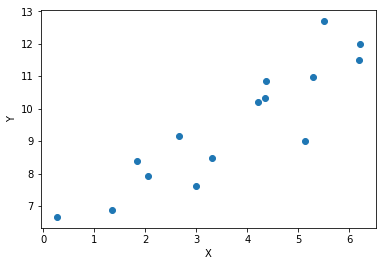

In [183]:
x = [q[i][0] for i in range(0,len(q))]
y = [q[i][1] for i in range(0,len(q))]
plt.scatter(x,y)
plt.xlabel('X')
plt.ylabel('Y')


**Problem 2 (2 points):** Based on this plot, what kind of functional relationship do $X$ and $Y$ seem to have?  Do you think these variables are positively or negatively correlated?  Why?

There is relatively positive, linear relationship between X and Y. The positive correlation derives from the increase in one value and the increase of the other value.

Let's now compute some statistics to better understand the relationship between $X$ and $Y$.
In the problems below, where appropriate, you will find the numpy functions `mean`, `cov`, `var`, and `corrcoef` to be useful. 

Remember that there are two ways to calculate variance, dividing by $N$ and dividing by $N-1$ (Note numpy and pandas have slightly different implementations of variance; one uses n-1, the other weights by n). You may use either, but be consistent. To make your code clearer, feel free to create variables for values that you use repeatedly. You can use them across cells. 

**Problem 3 (1 point):** Calculate the variance of $X$ and the variance of $Y$ using numpy. **Here and in every problem below, print your results with informative labeling!** 

In [184]:
print("{:.2f} is the variance of X".format(np.var(x)))
print("{:.2f} is the variance of Y".format(np.var(y)))

3.12 is the variance of X
3.29 is the variance of Y


**Problem 4 (2 pts):** Calculate the variance of $X$ and the variance of $Y$ manually (without numpy).  Note: You can still use numpy's mean function.


In [185]:
xmean = np.mean(x)
ymean = np.mean(y)

xvar = 0
yvar = 0

for i in range(0, len(q)):
    xvar = xvar + (x[i] - xmean)**2
    yvar = yvar + (y[i] - ymean)**2
xvar = xvar/len(x)
yvar = yvar/len(y)

print("{:.2f} is the variance of X".format(xvar))
print("{:.2f} is the variance of Y".format(yvar))

3.12 is the variance of X
3.29 is the variance of Y


**Problem 5 (1 point)**: Calculate the covariance of $X$ and $Y$ using numpy.

In [186]:
cov = np.cov(x,y)[0,1]
print('covariance of x,y: ', round(cov,2))

covariance of x,y:  3.08


**Problem 6 (2 points):** Calculate the correlation between $X$ and $Y$ without using numpy, by combining your answers from previous problems.

In [189]:
cr = cov/(xvar*yvar)**0.5
print('correlation of x,y: ', round(cr,2))

correlation of x,y:  0.96


### B. Linear Regression
 
Let's now test how well the relationship between $Y$ and $X$ can be described using a linear model.

**Problem 7 (6 points):** Using sklearn, fit a simple linear regression model to predict $Y$ from $X$. (If you're unsure of how to do this, the documentation will prove useful.)

After fitting this model, print its slope and intercept, then produce a scatter plot showing the "in sample" predictions of this model (i.e. predictions at the points at which this this model was trained), alongside the observed values of $Y$.  Note that both scatterplots should be placed on the same graph.  Use a legend to indicate which points correspond to predictions, and which points correspond to true values.   

Estimated slope:  [0.92294814]
Estimated intercept:  6.083516562436524


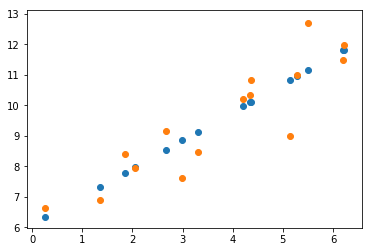

In [190]:
linear_model = lr() 
values = linear_model.fit(np.asarray(x).reshape(-1,1),y) 
 
print('Estimated slope: ', linear_model.coef_)
print('Estimated intercept: ',linear_model.intercept_)
y_predict = linear_model.predict(np.asarray(x).reshape(-1,1))

plt.scatter(x, y_predict)
plt.scatter(x,y)


**Problem 8 (3 points):**.
Looking at the data, a linear relationship between $Y$ and $X$ seems like a reasonable assumption.  However, linear regression also assumes that the residuals, or the differences between model predictions and observed values of $Y$, are (i) independent and (ii) identically distributed (i.e. homoskedasticity).  Let's test this assumption.  

Produce another scatter plot, with observed values of $X$ on the x axis, and with the residuals $r_i = y_i - \hat{y}_i$, where $\hat{y}_i = f(x_i)$ is our predicted value for $x_i$ under (our linear regression model) $f$.  Based on this scatterplot, do you think the assumptions (i) and (ii) are satisfied?

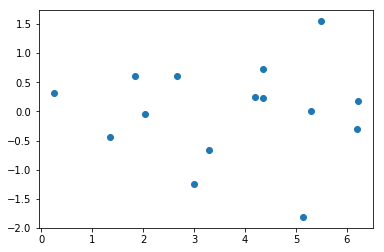

In [191]:
residuals = y-y_predict
plt.scatter(x,residuals) 

It doesn't meet the homoskedasticity requirement. As the value of x increases, the magnitudes of the residuals progressively increase.

**Problem 9 (3 points):** 

Finally, let's quantify how well our linear regression modeled the data.  Compute and print the coefficient of determination (i.e. $r^2$) for this model, on this data **using the formula below (NOT via `numpy` or `pandas` `.corr()` method)**:

$$r^2 = 1 - \frac{SSR}{SST}$$

where 

$$SSR = \sum_{i=1}^n r_i^2$$

$$SST = \sum_{i=1}^n (y_i-\bar{y})^2$$

Note: Sometimes the terminology $r^2 = 1 - \frac{MSE(y,\hat{y})}{Var(y)}$ is used, where MSE = mean squared error. Ponder why these definitions are equivalent, when using $N$ in the denominator of your variance calculation.  In the future, you can automatically perform this calculation using `LinearRegression`'s built in `score` method, or by calling `sklearn.metrics.r2_score`.

Based on your findings, how well is $Y$ explained by $X$ in the context of a our model (be precise and quantitative in your answer).  How does this $r^2$ score relate to the corr($X,Y$)?

In [192]:
SSR = sum(residuals**2)
SST = sum((y-ymean)**2)
coeff_det = 1-SSR/SST

print('Coefficient of determination: ', round(coeff_det,3))


Coefficient of determination:  0.807


A less than 20% variance in Y over X implies that Y is explained relatively effectively. The square root of this value gives about 0.9 which is close to the correlation calculated correlation of 0.96. 

## C:  Making data with a desired correlation

To help you better understand correlation, you'll now create datasets that have a prescribed correlation.

Note that in practice, due to randomness, it will be hard to get exact results.  Instead, round your empirical correlations to two decimal places and, whenever relevent, be sure to generate lots (10000+) of random variables to ensure reproducible results.


**Problem 10 (1 point):** Create two arrays, x, y, whose correlation is 1.0. **Calculate $Corr(x,y)$.**

In [193]:
x = np.round(10*np.random.rand(10000),2)
y = 2*x - 4
corr = np.round(np.corrcoef(x,y)[0,1],2)
print('Coefficient coefficient of x and y: ', corr)


Coefficient coefficient of x and y:  1.0



**Problem 11 (1 point):** Using the same x values from your answer to  problem 10, create a second array, `y2`, that also has perfect correlation with `x`, but which is not identical to your `y` from the previous problem. **Print your observed correlation coefficient between `x` and `y2`.**

In [194]:
y2 = x/4 + 20
corr2 = np.round(np.corrcoef(x,y2)[0,1],2)
print('Correlation coefficient of x and y2: ', corr2)

Correlation coefficient of x and y2:  1.0



**Problem 12 (1 point):** Create two arrays with correlation close to 0, which are independent of each other, and print the correlation of your data.  

In [196]:
A = np.random.normal(0,1,10000)
B = np.random.normal(0,1,10000)
cor = np.round(np.corrcoef(A,B)[0,1],2)
print('Correlation coefficient of A and B: ', cor)


Correlation coefficient of A and B:  -0.01


**Problem 13 (3 points):** Create two arrays with correlation **$r = $** 0.5 (+/- 0.01) by adding noise. First create $X$. Then create a new array `noise` of the same length using `numpy.random.normal()` with mean zero and standard deviation 1.0. Hint: Set a variable `scale`, initially equal to 1.0. Let $Y$ equal $X$ plus `scale` times `noise` and calculate $r$. If $r$ is greater than or less than 0.5, change the value of `scale` and repeat. It's OK to do this by brute force, or by figuring out how to search for the correct value of `noise` in a computationally efficient way.  **Print your scale factor and $r$.**

In [198]:
X = np.random.normal(0,1,10000)
scale = 1.75
noise = np.random.normal(0,1,10000)

Y = X + scale*noise

cor = np.round(np.corrcoef(X,Y)[0,1],2)
print('Correlation coefficient of X and Y: ', cor)

Correlation coefficient of X and Y:  0.5


**Problem 14 (3 points):** Two variables which are independent have 0 correlation, but the reverse statement is not always true.  Create an array $X$, and then generate an array $Y$ that is a deterministic function of $X$, but where the correlation between $X$ and $Y$ is near 0. In other words, given $X$, you know *exactly* what $Y$ will be, but the $r$  value is still close to 0.  Hint: You've seen an example of this in lecture (https://en.wikipedia.org/wiki/Pearson_correlation_coefficient#/media/File:Correlation_examples2.svg)


In [199]:
X = np.random.normal(0,1,10000)
Y = (1-X**2)**2
cor = np.round(np.corrcoef(X,Y)[0,1],2)
print('Correlation coefficient of X and Y: ', cor)

Correlation coefficient of X and Y:  -0.0
